## Import needed libraries

In [ ]:
import json
import random
import numpy as np
import pandas as pd
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import csv

print("Libraries imported.")

Libraries imported.


## Load data

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd content/drive/MyDrive/Colab\ Notebooks/nodup_classification
%cd drive/MyDrive/Colab\ Notebooks/nodup_classification

%ls

/content/drive/MyDrive/Colab Notebooks/nodup_classification
blindtest.json                       c_matrix_SVC.eps
category_graph.eps                   New_Blindtest.csv
c_matrix_LogisticRegression.eps      New_Dataset.csv
c_matrix_MultinomialNB.eps           nodupblindtest.json
c_matrix_RandomForestClassifier.eps  noduplicatedataset.json


In [ ]:
dataset = 'noduplicatedataset.json'
df = pd.read_json(dataset, lines=True)
df.head(10)

,id,semantic,lista_asm,cfg
0,828,string,"['jmp qword ptr [rip + 0x220882]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
1,11786,math,"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...","{'directed': True, 'graph': [], 'nodes': [{'id..."
2,12621,encryption,"['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...","{'directed': True, 'graph': [], 'nodes': [{'id..."
3,11166,math,"['mov qword ptr [rsp - 0x10], rbx', 'mov qword...","{'directed': True, 'graph': [], 'nodes': [{'id..."
4,10432,sort,"['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
5,4176,encryption,"['push rbp', 'push r15', 'push r14', 'push r13...","{'directed': True, 'graph': [], 'nodes': [{'id..."
6,8323,encryption,"['push rbp', 'push r15', 'push r14', 'push r12...","{'directed': True, 'graph': [], 'nodes': [{'id..."
7,14389,encryption,"['push rbp', 'push rbx', 'mov r10, rdx', 'movz...","{'directed': True, 'graph': [], 'nodes': [{'id..."
8,6501,sort,"['push rbp', 'push r15', 'push r14', 'push r13...","{'directed': True, 'graph': [], 'nodes': [{'id..."
9,1141,string,"['jmp qword ptr [rip + 0x200b92]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."


For easier use, create a csv file including only necessary data from the json file


In [ ]:
data = []
for line in open("noduplicatedataset.json", "r"):
    data.append(json.loads(line))
content, label = [], []
for each in data:
    content.append(each['lista_asm'])
    label.append(each['semantic'])
df = pd.DataFrame([content, label]).T
df.columns = ['content', 'label']
print(df.head())
'''create a csv dataset file using json dataset file'''
df.to_csv('New_Dataset.csv', index = False)

                                             content       label
0  ['jmp qword ptr [rip + 0x220882]', 'jmp qword ...      string
1  ['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...        math
2  ['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...  encryption
3  ['mov qword ptr [rsp - 0x10], rbx', 'mov qword...        math
4  ['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...        sort


## Exploring the Data

Once created the file csv it is possible to start directly from this point (remember to include the folder data).
First, load all the necessary libraries needed to implement the entire solution.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print("Libraries imported.")

Libraries imported.


Load and visualize the dataset.

In [ ]:
# loading data
df = pd.read_csv("New_Dataset.csv")
print(df.shape)
df.head()

(6073, 2)


,content,label
0,"['jmp qword ptr [rip + 0x220882]', 'jmp qword ...",string
1,"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...",math
2,"['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...",encryption
3,"['mov qword ptr [rsp - 0x10], rbx', 'mov qword...",math
4,"['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...",sort


Check null values in the dataset.

In [ ]:
# Percentage of not null data
total = df['content'].notnull().sum()
round((total/len(df)*100),1)

100.0

Unique labels from the dataset

In [ ]:
pd.DataFrame(df.label.unique())

,0
0,string
1,math
2,encryption
3,sort


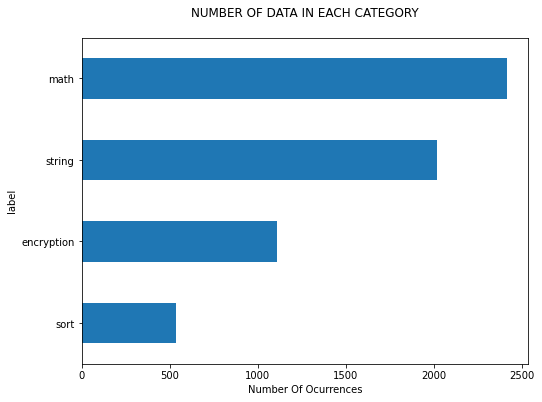

In [ ]:
# Bar chart to show the number of instances per category
fig = plt.figure(figsize=(8,6))
df.groupby('label').content.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF DATA IN EACH CATEGORY\n')
plt.xlabel('Number Of Ocurrences', fontsize = 10);
plt.savefig('category_graph.eps', bbox_inches='tight')

## Data Pre-Processing

In [ ]:
# Content of some data
df.content[0]
df.content[1]

"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm0, xmm1', 'jp 0x3a', 'pxor xmm3, xmm3', 'ucomisd xmm3, xmm1', 'jae 0x3e', 'ucomisd xmm3, xmm2', 'jae 0x34', 'pxor xmm3, xmm3', 'ucomisd xmm3, xmm0', 'jb 0x4d', 'test edi, edi', 'je 0x31', 'movapd xmm2, xmm3', 'test esi, esi', 'je 0x28', 'movsd xmm2, qword ptr [rip + 0xde]', 'divsd xmm2, xmm3', 'jmp 0x20', 'addsd xmm0, xmm1', 'addsd xmm2, xmm0', 'jmp 0x12', 'pxor xmm2, xmm2', 'divsd xmm2, xmm2', 'movapd xmm0, xmm2', 'ret ', 'movapd xmm0, xmm2', 'ret ', 'pxor xmm2, xmm2', 'test esi, esi', 'jne 0xfffffffffffffffb', 'movsd xmm2, qword ptr [rip + 0xa9]', 'jmp 0xfffffffffffffff3', 'push rbp', 'push rbx', 'sub rsp, 8', 'mov ebp, esi', 'mov ebx, edi', 'divsd xmm0, xmm2', 'call 0x13', 'movapd xmm2, xmm0', 'xorpd xmm2, xmmword ptr [rip + 0xa8]', 'test ebx, ebx', 'je 0x71']"

Remove irrelevant characters: simple text cleaning steps such as removing white spaces and numbers, removing symbols & puncuations, convert text to lowercase etc.
The aim is to have only relevant data for the features identification.
These are contained in the characters of interest list.

In [ ]:
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

# Characters of interest
char_of_int_lst = ['not','and','or','xor','sal','sar','shr','shl',
                   'cmp','test','mov',
                   'xmm',
                   'ucomis']
def clean_text(text):
    """
        text: a string
        
        return: modified string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(" \d+", " ", text) # remove digits
    text = re.sub(" #\d+", " ", text) # remove digits starting with # symbol
    text = ' '.join(word for word in text.split() if any(ch in word for ch in char_of_int_lst)) # delete stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)
df.head(10)



,content,label
0,qword qword qword mov mov dword cmp dword mov ...,string
1,ucomisd xmm2 xmm2 ucomisd xmm0 xmm1 pxor xmm3 ...,math
2,mov mov qword mov qword xor word mov dword sar...,encryption
3,mov qword mov qword movsd qword xmm0 mov mov m...,math
4,qword qword qword mov xor mov xor mov cmp dwor...,sort
5,mov qword mov qword mov qword xor qword xor qw...,encryption
6,xorps xmm0 xmm0 movaps xmmword xmm0 movaps xmm...,encryption
7,mov movzx shl movzx shl or movzx shl or movzx ...,encryption
8,mov cmp movsxd mov mov qword mov qword mov xor...,sort
9,qword qword qword qword mov mov mov mov qword ...,string


Example of content associated to each label

In [ ]:
print("String:")
df.content[0]


String:


'qword qword qword mov mov dword cmp dword mov mov qword cmp qword mov qword cmp dword mov qword cmp qword mov qword mov mov mov qword cmp qword mov qword mov qword mov dword mov dword mov dword mov mov dword movsxd dword mov qword mov qword mov qword cmp qword mov dword mov dword movsxd dword mov qword mov qword mov qword cmp qword mov qword mov mov qword mov dword mov qword mov dword mov dword mov qword mov dword cmp dword mov qword mov qword mov qword mov qword movsxd dword mov qword movsxd dword mov qword mov qword mov mov qword mov qword mov qword mov qword'

In [ ]:
print("Math:")
df.content[1]

Math:


'ucomisd xmm2 xmm2 ucomisd xmm0 xmm1 pxor xmm3 xmm3 ucomisd xmm3 xmm1 ucomisd xmm3 xmm2 pxor xmm3 xmm3 ucomisd xmm3 xmm0 test movapd xmm2 xmm3 test movsd xmm2 qword xmm2 xmm3 xmm0 xmm1 xmm2 xmm0 pxor xmm2 xmm2 xmm2 xmm2 movapd xmm0 xmm2 movapd xmm0 xmm2 pxor xmm2 xmm2 test movsd xmm2 qword mov mov xmm0 xmm2 movapd xmm2 xmm0 xorpd xmm2 xmmword test'

In [ ]:
print("Encryption:")
df.content[2]

Encryption:


'mov mov qword mov qword xor word mov dword sar shr mov and mov shr sar movzx and shl movzx mov and shr mov sar shr sar movsxd movzx or mov cmp mov dword sar shr mov and mov shr sar movzx and shl movzx mov and shr mov sar shr sar movsxd movzx or mov cmp mov dword mov dword mov dword mov dword mov word mov dword mov word mov dword xor word mov dword sar shr mov and mov shr sar movsxd movzx and shl movzx mov and shr mov sar shr sar movsxd movzx or mov cmp mov dword mov word mov dword xor word mov dword sar shr mov and mov shr sar movsxd movzx and shl movzx mov and shr mov sar shr sar movsxd movzx or mov cmp mov dword sar shr mov and mov shr sar movsxd movzx and shl movzx mov and shr mov sar shr sar movsxd movzx or mov cmp mov test cmovne movsxd shl xor dword movzx xor cmp movzx xor cmp mov dword mov mov mov shr and mov shr and or mov shr and movzx shl movzx or mov dword shl or dword mov and mov shr and or shl and shr or movzx shl movzx or or dword mov mov mov mov shr and mov shr and or a

In [ ]:
print("Sort:")
df.content[4]

Sort:


'qword qword qword mov xor mov xor mov cmp dword xor mov xor mov mov xor mov movsxd dword cmp test xor word test test movsxd mov dword mov dword cmp mov dword mov dword cmp cmp test xor dword mov dword mov xor mov dword mov xor movsxd dword cmp'

In [ ]:
# Create a new column 'label_id' with encoded categories 
df['label_id'] = df['label'].factorize()[0]
new_df = df[['label', 'label_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['label_id', 'label']].values)
# New dataframe
df.head(10)

,content,label,label_id
0,qword qword qword mov mov dword cmp dword mov ...,string,0
1,ucomisd xmm2 xmm2 ucomisd xmm0 xmm1 pxor xmm3 ...,math,1
2,mov mov qword mov qword xor word mov dword sar...,encryption,2
3,mov qword mov qword movsd qword xmm0 mov mov m...,math,1
4,qword qword qword mov xor mov xor mov cmp dwor...,sort,3
5,mov qword mov qword mov qword xor qword xor qw...,encryption,2
6,xorps xmm0 xmm0 movaps xmmword xmm0 movaps xmm...,encryption,2
7,mov movzx shl movzx shl or movzx shl or movzx ...,encryption,2
8,mov cmp movsxd mov mov qword mov qword mov xor...,sort,3
9,qword qword qword qword mov mov mov mov qword ...,string,0


##Feature Extraction


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')
# We transform each news data into a vector
features = tfidf.fit_transform(df.content).toarray()
labels = df.label_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams, bigrams, trigrams)" %(features.shape))

Each of the 6073 news data is represented by 5412 features (TF-IDF score of unigrams, bigrams, trigrams)


Show the three most correlated terms with each category

In [ ]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
  print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))


==>  encryption :
  * Most Correlated Unigrams are: shr, ror, shl
  * Most Correlated Bigrams are: dword shr, movzx xor, xor dword
  * Most Correlated Trigrams are: xor dword xor, dword xor dword, xor dword mov

==>  math :
  * Most Correlated Unigrams are: xmm1, xmm0, movsd
  * Most Correlated Bigrams are: xmm0 qword, qword xmm0, movsd qword
  * Most Correlated Trigrams are: movsd qword xmm1, movsd xmm0 qword, movsd qword xmm0

==>  sort :
  * Most Correlated Unigrams are: movsd, ucomiss, word
  * Most Correlated Bigrams are: qword cmp, word mov, qword word
  * Most Correlated Trigrams are: cmp qword test, mov qword word, mov qword qword

==>  string :
  * Most Correlated Unigrams are: xmm0, movsxd, movsd
  * Most Correlated Bigrams are: test cmp, dword test, test mov
  * Most Correlated Trigrams are: mov dword test, test mov dword, mov qword test


##Split the Dataset into Training & Testing Sets

In [ ]:
X = df['content'] # collection of news data
y = df['label'] # labels(i.e.,for the 4 different news categories)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
print("shape of x_train set :", X_train.shape)
print("shape of y_train set :",y_train.shape)
print("shape of x_test set :",X_test.shape)
print("shape of y_test set :",y_test.shape)

shape of x_train set : (4554,)
shape of y_train set : (4554,)
shape of x_test set : (1519,)
shape of y_test set : (1519,)


##Model Selection

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

 Cross-validation to get the performance for each model

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.987818,0.015423
LogisticRegression,0.980079,0.018024
MultinomialNB,0.906967,0.015786
RandomForestClassifier,0.888032,0.017320


##Build Model & Evaluate

Split the dataset

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)

LinearSVC evaluation

In [ ]:
model1 = LinearSVC(random_state=0)
start = time.time()
model1.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model1.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['label'].unique()))

Training time: 0.21102046966552734s
			CLASSIFICATION REPORT

              precision    recall  f1-score   support

      string       0.99      1.00      0.99       484
        math       1.00      0.99      0.99       639
  encryption       0.99      0.99      0.99       269
        sort       0.97      0.95      0.96       127

    accuracy                           0.99      1519
   macro avg       0.99      0.98      0.98      1519
weighted avg       0.99      0.99      0.99      1519



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1:",metrics.f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.990125082290981
Precision: 0.9857824337942886
Recall: 0.9834662935524778
F1: 0.9845973822168206


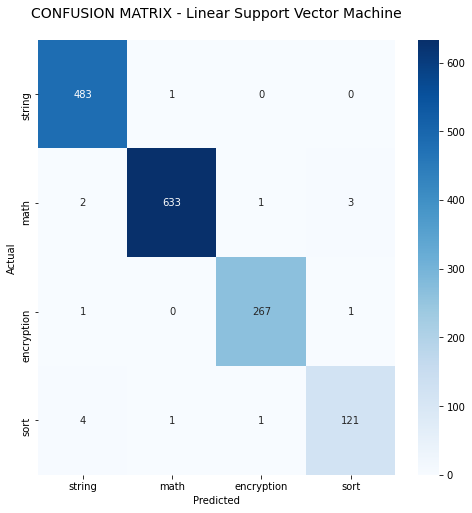

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.label.values, 
            yticklabels=new_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear Support Vector Machine\n", size=14)
plt.savefig('c_matrix_SVC.eps', bbox_inches='tight')

LogisticRegression evaluation

In [ ]:
model2 = LogisticRegression(random_state=0)
start = time.time()
model2.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model2.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['label'].unique()))

Training time: 8.452704191207886s
			CLASSIFICATION REPORT

              precision    recall  f1-score   support

      string       0.97      0.99      0.98       484
        math       1.00      0.98      0.99       639
  encryption       0.99      0.99      0.99       269
        sort       0.91      0.87      0.89       127

    accuracy                           0.98      1519
   macro avg       0.96      0.96      0.96      1519
weighted avg       0.98      0.98      0.98      1519



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1:",metrics.f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.978275181040158
Precision: 0.9649008615091115
Recall: 0.9593245150447627
F1: 0.9619698914604277


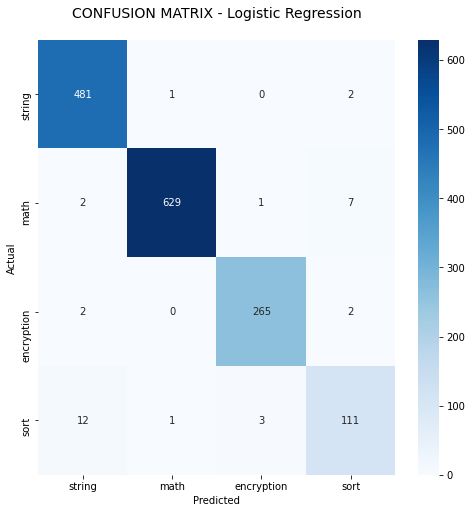

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.label.values, 
            yticklabels=new_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=14)
plt.savefig('c_matrix_LogisticRegression.eps', bbox_inches='tight')

MultinomialNB evaluation

In [ ]:
model3 = MultinomialNB()
start = time.time()
model3.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model3.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['label'].unique()))

Training time: 0.14189505577087402s
			CLASSIFICATION REPORT

              precision    recall  f1-score   support

      string       0.79      0.99      0.88       484
        math       1.00      0.96      0.98       639
  encryption       1.00      0.96      0.98       269
        sort       0.76      0.20      0.32       127

    accuracy                           0.91      1519
   macro avg       0.89      0.78      0.79      1519
weighted avg       0.91      0.91      0.89      1519



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1:",metrics.f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.9078341013824884
Precision: 0.886528253109682
Recall: 0.7790894278669656
F1: 0.789238665636196


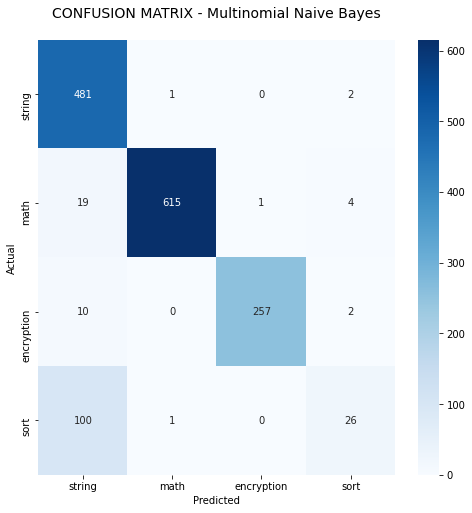

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.label.values, 
            yticklabels=new_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Naive Bayes\n", size=14)
plt.savefig('c_matrix_MultinomialNB.eps', bbox_inches='tight')

RandomForestClassifier evaluation

In [ ]:
model4 = RandomForestClassifier(random_state=0)
start = time.time()
model4.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model4.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['label'].unique()))

Training time: 3.5379371643066406s
			CLASSIFICATION REPORT

              precision    recall  f1-score   support

      string       0.98      1.00      0.99       484
        math       1.00      0.99      0.99       639
  encryption       0.99      0.99      0.99       269
        sort       0.95      0.94      0.95       127

    accuracy                           0.99      1519
   macro avg       0.98      0.98      0.98      1519
weighted avg       0.99      0.99      0.99      1519



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1:",metrics.f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.9881500987491771
Precision: 0.9812527599618346
Recall: 0.9800518926601103
F1: 0.980631185215694


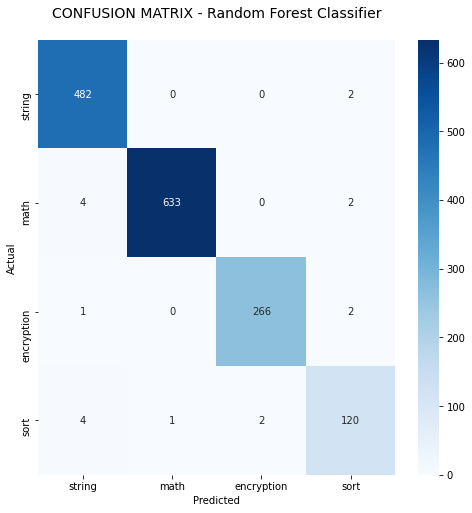

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.label.values, 
            yticklabels=new_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest Classifier\n", size=14)
plt.savefig('c_matrix_RandomForestClassifier.eps', bbox_inches='tight')

## Blind test & Prediction 

In [ ]:
data = []
for line in open("blindtest.json", "r"):
    data.append(json.loads(line))
content, label = [], []
for each in data:
    content.append(each['lista_asm'])
#    label.append(each['semantic'])
df = pd.DataFrame([content]).T
df.columns = ['content']
print(df.head())
'''create a csv dataset file using json dataset file'''
df.to_csv('New_Blindtest.csv', index = False)

                                             content
0  ['jmp qword ptr [rip + 0x203b72]', 'jmp qword ...
1  ['sub rsp, 0x28', 'mov rax, qword ptr fs:[0x28...
2  ['jmp qword ptr [rip + 0x200bc2]', 'jmp qword ...
3  ['jmp qword ptr [rip + 0x2177ea]', 'jmp qword ...
4  ['ucomisd xmm1, xmm1', 'movapd xmm7, xmm0', 'm...


In [ ]:
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))
char_of_int_lst = ['not','and','or','xor','sal','sar','shr','shl',
                   'cmp','test','mov',
                   'xmm',
                   'ucomis']
def clean_text(text):
    """
        text: a string
        
        return: modified string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(" \d+", " ", text) # remove digits
    text = re.sub(" #\d+", " ", text) # remove digits starting with # symbol
    text = ' '.join(word for word in text.split() if any(ch in word for ch in char_of_int_lst)) # delete stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)
df.head(10)



,content
0,qword qword qword qword mov mov mov mov mov mo...
1,mov qword mov qword xor ucomisd xmm0 xmm0 mov ...
2,qword qword qword mov mov test mov mov dword m...
3,qword qword qword qword mov cmp mov xor test m...
4,ucomisd xmm1 xmm1 movapd xmm7 xmm0 movapd xmm5...
5,qword mov mov qword mov qword cmp qword mov mo...
6,mov mov qword mov dword mov qword mov qword mo...
7,mov mov xor mov word movsxd mov shr sar mov mo...
8,test xor word mov dword test mov mov dword tes...
9,movapd xmm3 xmm1 xmm3 xmm2 movapd xmm14 xmm3 x...


In [ ]:
X_test = tfidf.transform(df['content'])

model = model1 #set model1 (linearSVC), model2 (LogisticRegression), model3 (MultinomialNB), model4 (RandomForestClassifier)

y_pred = model.predict(X_test)

#print(y_pred)

for i in range(len(y_pred)): 
  if y_pred[i] == 0:
    print ("string")
  elif y_pred[i] == 1:
    print ("math")
  elif y_pred[i] == 2:
    print ("encryption")
  elif y_pred[i] == 3:
    print ("sort")

encryption
math
string
string
math
string
encryption
encryption
sort
math
math
math
sort
encryption
sort
math
string
string
math
math
math
string
encryption
math
encryption
string
string
math
math
sort
math
string
sort
sort
string
sort
string
math
sort
string
string
math
sort
math
sort
sort
sort
string
string
string
sort
math
math
string
math
string
math
math
math
math
encryption
sort
math
string
string
sort
math
string
sort
sort
encryption
encryption
string
sort
math
sort
sort
sort
sort
sort
sort
encryption
math
sort
string
math
string
math
encryption
math
string
string
string
sort
sort
string
math
encryption
encryption
encryption
math
sort
sort
sort
encryption
math
math
math
math
sort
encryption
string
sort
string
string
encryption
math
sort
sort
string
encryption
math
math
encryption
math
encryption
math
string
sort
encryption
encryption
string
sort
encryption
string
sort
math
string
encryption
math
math
encryption
math
math
sort
encryption
math
sort
encryption
math
math
math
string

In [ ]:
# save the model
model_filename = open('finalized_model.sav', 'wb')
pickle.dump(model, model_filename)
model_filename.close()
# save fitted vectorizer to use for the prediction time
tf_idf_output = open('fitted_vectorizer.pickle', 'wb')
pickle.dump(fitted_vectorizer, tf_idf_output)
tf_idf_output.close()
# save the dictionaries
output1 = open('category_to_id.pkl', 'wb')
pickle.dump(category_to_id, output1)
output1.close()
output2 = open('id_to_category.pkl', 'wb')
pickle.dump(id_to_category, output2)
output2.close()

In [ ]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Restore tuple
pickled_model, pickled_Xtrain, pickled_Ytrain, pickled_score = pickle.load(open("tuple_model.pkl", 'rb'))
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(Xtest, Ytest)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(Xtest)